# State Farm Kaggle Submission

This notebook covers a step-by-step approach to the [State Farm Distracted Driver Detection Kaggle Competition](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data), which follows [Jeremy's submission](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm.ipynb) from the course. Before starting our submission, follow steps 3-5 from the "Setting Up Kaggle" section in the [Lesson 2](https://github.com/fdaham/fastai/blob/master/lesson2.ipynb) notebook.

Here are a few configuration steps:

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import os, sys
from __future__ import print_function, division
path = 'data/statefarm/'
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

Using Theano backend.


## Step 1: Creating Batches

The goal of our model for this competition is to predict whether an image contains a distracted driver (one that is texting, calling, eating, etc.) and the likelihood of what they're doing. The 10 classes to predict are:

* c0: safe driving
* c1: texting (right)
* c2: talking on the phone (right)
* c3: texting (left)
* c4: talking on the phone (left)
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

The compeition only provides a ```train``` and ```test``` set. To create a ```valid``` set, we'll need to move ~20% of the images from ```train``` and create subfolders for each class:

```python
% cd ~/nbs/data/statefarm
% mkdir valid
% cd valid
% mkdir [insert c0-c9]
```

Randomly choosing 20% of the images from the corpus will not suffice as the same driver can't exist in both ```train``` and ```valid``` (per the competition's rules). This is pretty obvious when you consider how easy it would be for the model, after training, to recognize a driver from an image and predict the respective distraction class. Instead, from the 26 total drivers, we will randomly select 5 and copy all of their classes to ```valid```. 

In [3]:
# read in driver_imgs_list.csv
df = pd.read_csv('~/nbs/data/statefarm/driver_imgs_list.csv')

In [4]:
# select 5 random drivers for the validation set
import random
drivers = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
drivers_valid = random.sample(drivers, 5)

In [5]:
# filter df by selecting rows with subjects we want
df = df[df['subject'].isin(drivers_valid)]

# move files from train to valid
i = 0
import shutil
for index, row in df.iterrows():
    to_move = '/home/ubuntu/nbs/' + path + 'train' + '/' +  row['classname'] + '/' + row['img']
    i = i + 1
    move_to = '/home/ubuntu/nbs/' + path + 'valid' + '/' +  row['classname']
    shutil.move(to_move, move_to)

In [3]:
batch_size = 64
batches = get_batches(path + 'train', batch_size=batch_size)
val_batches = get_batches(path + 'valid', batch_size=batch_size*2, shuffle=False)

Found 18316 images belonging to 10 classes.
Found 4108 images belonging to 10 classes.


You'll also want to move all of the test files to an ```unknown``` subfolder to have all the test images saved under an "unknown" class:

```python
% cd ~/nbs/data/statefarm/test/
% mkdir unknown
% mv *.jpg unknown/
```

We can now get our training and validation batches as well as our classes:

In [4]:
% cd ~/nbs/

/home/ubuntu/nbs


In [5]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 18316 images belonging to 10 classes.
Found 4108 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


## Step 2: Building the Model

Hyperparameter tuning and architecture modification for the model was completed on a random sample set of the training data. The process is detailed in [this notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm-sample.ipynb). We'll use this model on our full training data set. 

### Simple CNN

We see that using a CNN is optimal here for processing the driver images. So, we'll start by building our CNN, which includes two convolutional layers with maxpooling followed by a simple dense network, ending with ```softmax```:

In [6]:
def conv1(batches):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model

In [7]:
# create model object
model = conv1(batches)

Epoch 1/2
18316/18316 [==============================] - 335s - loss: 0.2421 - acc: 0.9385 - val_loss: 1.8704 - val_acc: 0.4343
Epoch 2/2
18316/18316 [==============================] - 277s - loss: 0.0176 - acc: 0.9983 - val_loss: 1.4562 - val_acc: 0.5353
Epoch 1/4
18316/18316 [==============================] - 286s - loss: 0.0058 - acc: 0.9997 - val_loss: 1.5105 - val_acc: 0.5212
Epoch 2/4
18316/18316 [==============================] - 276s - loss: 0.0030 - acc: 0.9999 - val_loss: 1.6094 - val_acc: 0.5341
Epoch 3/4
18316/18316 [==============================] - 276s - loss: 0.0020 - acc: 0.9999 - val_loss: 1.5558 - val_acc: 0.5387
Epoch 4/4
18316/18316 [==============================] - 278s - loss: 0.0013 - acc: 1.0000 - val_loss: 1.5189 - val_acc: 0.5472


In the absence of regularization or augmentation, our simple CNN is generating high training accuracies. Our training set quickly nears 100%, but our validation accuracy remains low (below 55%). Overfitting is the issue here. We can further improve our results by adding data augmentation to our network. 

### CNN with Data Augmentation

Here, we will create a generator and add our training batches to it:

In [8]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 18316 images belonging to 10 classes.


We pass the data through all the convolutional and fully connected layers in order to train our model:

In [9]:
model = conv1(batches)

Epoch 1/2
18316/18316 [==============================] - 293s - loss: 1.2781 - acc: 0.5887 - val_loss: 2.0166 - val_acc: 0.3354
Epoch 2/2
18316/18316 [==============================] - 286s - loss: 0.6409 - acc: 0.8063 - val_loss: 1.6026 - val_acc: 0.5667
Epoch 1/4
18316/18316 [==============================] - 292s - loss: 0.4384 - acc: 0.8720 - val_loss: 1.7394 - val_acc: 0.5504
Epoch 2/4
18316/18316 [==============================] - 289s - loss: 0.3445 - acc: 0.9010 - val_loss: 1.4562 - val_acc: 0.6239
Epoch 3/4
18316/18316 [==============================] - 290s - loss: 0.2864 - acc: 0.9199 - val_loss: 1.3459 - val_acc: 0.6519
Epoch 4/4
18316/18316 [==============================] - 287s - loss: 0.2411 - acc: 0.9351 - val_loss: 1.3018 - val_acc: 0.6692


In [10]:
model.optimizer.lr = 0.0001
model.fit_generator(batches, batches.nb_sample, nb_epoch=15, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/15
18316/18316 [==============================] - 294s - loss: 0.2049 - acc: 0.9452 - val_loss: 1.1094 - val_acc: 0.7169
Epoch 2/15
18316/18316 [==============================] - 285s - loss: 0.1751 - acc: 0.9527 - val_loss: 1.8049 - val_acc: 0.6030
Epoch 3/15
18316/18316 [==============================] - 282s - loss: 0.1634 - acc: 0.9555 - val_loss: 1.2687 - val_acc: 0.6670
Epoch 4/15
18316/18316 [==============================] - 288s - loss: 0.1459 - acc: 0.9606 - val_loss: 1.0560 - val_acc: 0.7232
Epoch 5/15
18316/18316 [==============================] - 284s - loss: 0.1318 - acc: 0.9639 - val_loss: 1.4600 - val_acc: 0.6453
Epoch 6/15
18316/18316 [==============================] - 284s - loss: 0.1287 - acc: 0.9643 - val_loss: 1.1046 - val_acc: 0.7016
Epoch 7/15
18316/18316 [==============================] - 285s - loss: 0.1095 - acc: 0.9704 - val_loss: 1.3249 - val_acc: 0.6935
Epoch 8/15
18316/18316 [==============================] - 285s - loss: 0.1160 - acc: 0.9681 - val

Without the use of dropout or semi-supervised learning, our simple model is able to achieve great results. Data augmentation has definitely helped in increasing our validation accuracy. Notice all of the forms of data augmentation used here: shifting, rotating, and shearing the images as well as shifting the channel colors. However, the results are still unstable; varying between 35-70% every epoch. To solve this issue, we introduce dropout to our model while adding more convolutional/pooling layers and changing the learning rate.

### CNN with Data Augmentation and Dropout

In [11]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 18316 images belonging to 10 classes.


In [12]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(128,3,3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

In [13]:
model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
18316/18316 [==============================] - 295s - loss: 2.6436 - acc: 0.2478 - val_loss: 2.4034 - val_acc: 0.2442
Epoch 2/2
18316/18316 [==============================] - 295s - loss: 1.7218 - acc: 0.4493 - val_loss: 1.7596 - val_acc: 0.4976


In [15]:
model.optimizer.lr = 0.001

In [16]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=10, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/10
18316/18316 [==============================] - 303s - loss: 1.3302 - acc: 0.5692 - val_loss: 1.4778 - val_acc: 0.5781
Epoch 2/10
18316/18316 [==============================] - 297s - loss: 1.0222 - acc: 0.6592 - val_loss: 1.3796 - val_acc: 0.5981
Epoch 3/10
18316/18316 [==============================] - 298s - loss: 0.8232 - acc: 0.7236 - val_loss: 1.1852 - val_acc: 0.6378
Epoch 4/10
18316/18316 [==============================] - 296s - loss: 0.7317 - acc: 0.7577 - val_loss: 1.2535 - val_acc: 0.6650
Epoch 5/10
18316/18316 [==============================] - 300s - loss: 0.5996 - acc: 0.8027 - val_loss: 1.5723 - val_acc: 0.6288
Epoch 6/10
18316/18316 [==============================] - 299s - loss: 0.4994 - acc: 0.8351 - val_loss: 1.3585 - val_acc: 0.6210
Epoch 7/10
18316/18316 [==============================] - 297s - loss: 0.4441 - acc: 0.8572 - val_loss: 1.3773 - val_acc: 0.6587
Epoch 8/10
18316/18316 [==============================] - 297s - loss: 0.3866 - acc: 0.8739 - val

In [17]:
model.optimizer.lr = 0.00001

In [18]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=10, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/10
18316/18316 [==============================] - 302s - loss: 0.2923 - acc: 0.9045 - val_loss: 1.2752 - val_acc: 0.6835
Epoch 2/10
18316/18316 [==============================] - 301s - loss: 0.2632 - acc: 0.9144 - val_loss: 1.1221 - val_acc: 0.7271
Epoch 3/10
18316/18316 [==============================] - 300s - loss: 0.2475 - acc: 0.9224 - val_loss: 1.4208 - val_acc: 0.6767
Epoch 4/10
18316/18316 [==============================] - 300s - loss: 0.2305 - acc: 0.9257 - val_loss: 1.3154 - val_acc: 0.6736
Epoch 5/10
18316/18316 [==============================] - 301s - loss: 0.2176 - acc: 0.9302 - val_loss: 1.1683 - val_acc: 0.7123
Epoch 6/10
18316/18316 [==============================] - 298s - loss: 0.1998 - acc: 0.9360 - val_loss: 1.0641 - val_acc: 0.7254
Epoch 7/10
18316/18316 [==============================] - 296s - loss: 0.1923 - acc: 0.9383 - val_loss: 1.2291 - val_acc: 0.6865
Epoch 8/10
18316/18316 [==============================] - 295s - loss: 0.1879 - acc: 0.9429 - val

We see that adding dropout to our network has stabilized our validation accuracies, now only oscillating between 60-75%. 

### CNN with Data Augmentation, Dropout, and Pre-trained Weights

Because our data set is a bit small, we can use pre-trained VGG weights to pre-compute the output of the last convolutional layer (as we did in [Lesson 3](https://github.com/fdaham/fastai/blob/master/lesson3.ipynb), when we experimented with dropout). This helps to further improve our model. However, we can't apply the full extent of data augmentation to our network since we can't pre-compute an output that changes every image.

In [19]:
vgg = Vgg16()
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [20]:
conv_model = Sequential(conv_layers)

In [21]:
# batch shuffle must be set to False when pre-computing features
batches = get_batches(path+'train', batch_size=batch_size, shuffle=False)

Found 18316 images belonging to 10 classes.


In [22]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 18316 images belonging to 10 classes.
Found 4108 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [23]:
conv_feat = conv_model.predict_generator(batches, batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [24]:
save_array(path+'/conv_val_feat.dat', conv_val_feat)
save_array(path+'/conv_feat.dat', conv_feat)

In [25]:
import bcolz
conv_feat = bcolz.open(path+'/conv_feat.dat')
conv_val_feat = load_array(path+'/conv_val_feat.dat')
conv_val_feat.shape

(4108, 512, 14, 14)

In [26]:
test_batches = get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)

Found 79726 images belonging to 1 classes.


In [27]:
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [28]:
save_array(path+'/conv_test_feat.dat', conv_test_feat)

So far, we've pre-computed the output of the last convolutional layer. However, we need to create a network that takes in the output from the previous layer as input to predict our 10 classes. We can do this using a simplified version of VGG's dense layers:

In [29]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [30]:
p = 0.8

In [31]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

Train on 18316 samples, validate on 4108 samples
Epoch 1/1
18316/18316 [==============================] - 18s - loss: 1.6805 - acc: 0.5359 - val_loss: 4.8758 - val_acc: 0.0090


In [33]:
bn_model.optimizer.lr = 0.01

In [34]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 18316 samples, validate on 4108 samples
Epoch 1/2
18316/18316 [==============================] - 18s - loss: 0.3187 - acc: 0.9027 - val_loss: 6.0898 - val_acc: 0.0071
Epoch 2/2
18316/18316 [==============================] - 18s - loss: 0.1601 - acc: 0.9539 - val_loss: 6.7724 - val_acc: 0.0085


In [35]:
# save weights
bn_model.save_weights(path+'/conv8.h5')

We can pre-compute the augmented data to experiment with combining dropout and data augmentation on the pre-trained model. Let's start with using our usual parameters to create a data set of convolutional features:

In [36]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
da_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

Found 18316 images belonging to 10 classes.


In [37]:
da_conv_feat = conv_model.predict_generator(da_batches, da_batches.nb_sample)

In [38]:
save_array(path+'/da_conv_feat2.dat', da_conv_feat)

In [39]:
da_conv_feat = bcolz.open(path+'/da_conv_feat2.dat')

We'll also include the true training (non-augmented) data:

In [40]:
da_trn_labels = trn_labels

In [41]:
def get_bn_da_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [42]:
p = 0.8

In [43]:
bn_model = Sequential(get_bn_da_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Now we can train the model as usual, with pre-computed augmented data:

In [44]:
bn_model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

Train on 18316 samples, validate on 4108 samples
Epoch 1/1
18316/18316 [==============================] - 19s - loss: 3.4899 - acc: 0.1590 - val_loss: 2.6455 - val_acc: 0.0402


In [45]:
bn_model.optimizer.lr=0.01

In [46]:
bn_model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 18316 samples, validate on 4108 samples
Epoch 1/4
18316/18316 [==============================] - 19s - loss: 1.9545 - acc: 0.3366 - val_loss: 3.1301 - val_acc: 0.0226
Epoch 2/4
18316/18316 [==============================] - 20s - loss: 1.4444 - acc: 0.4771 - val_loss: 3.9355 - val_acc: 0.0141
Epoch 3/4
18316/18316 [==============================] - 19s - loss: 1.1768 - acc: 0.5805 - val_loss: 4.4540 - val_acc: 0.0110
Epoch 4/4
18316/18316 [==============================] - 19s - loss: 1.0191 - acc: 0.6380 - val_loss: 5.1068 - val_acc: 0.0127


In [47]:
bn_model.optimizer.lr=0.0001

In [48]:
bn_model.fit(da_conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels))

Train on 18316 samples, validate on 4108 samples
Epoch 1/4
18316/18316 [==============================] - 19s - loss: 0.9160 - acc: 0.6818 - val_loss: 5.4821 - val_acc: 0.0127
Epoch 2/4
18316/18316 [==============================] - 19s - loss: 0.8270 - acc: 0.7155 - val_loss: 5.7465 - val_acc: 0.0100
Epoch 3/4
18316/18316 [==============================] - 19s - loss: 0.7612 - acc: 0.7431 - val_loss: 6.0488 - val_acc: 0.0110
Epoch 4/4
18316/18316 [==============================] - 19s - loss: 0.7079 - acc: 0.7605 - val_loss: 6.3187 - val_acc: 0.0097


In [49]:
# save weights
bn_model.save_weights(path+'/da_conv8_1.h5')

## Step 3: Generating and Validating Predictions

Submissions for this competition are evaluated using the **multi-class logarithmic loss**, where $N$ is the number of images in the test set, $M$ is the number of image class labels, $y_{ij}$ is 1 if observation $i$ belongs to class $j$ and 0 otherwise, and $p_{ij}$ is the predicted probability that observation $i$ belongs to class $j$:

\begin{equation*}
logloss = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} log(p_{ij})
\end{equation*}

Each image should be paired with a set of predicted probabilities. The submitted probabilities for a given image are rescaled by Kaggle prior to being scored (each row is divided by the row sum) in order to avoid the extremes of the log function. As was done in the [Cats vs Dogs Kaggle competition](https://github.com/fdaham/fastai/blob/master/dogs_cats_kaggle.ipynb), we'll also clip our probabilities prior to submitting:

In [50]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

In [52]:
conv_test_feat = bcolz.open(path+'/conv_test_feat.dat')

In [53]:
preds = bn_model.predict(conv_test_feat, batch_size=batch_size*2)

In [54]:
subm = do_clip(preds,0.93)

Here, we'll need to create our submission file, where the header contains the image filename and the classes c0-c9 (as outlined above). 

In [55]:
subm_name = path+'/results/subm.gz'

In [56]:
classes = sorted(batches.class_indices, key=batches.class_indices.get)

In [57]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,own/img_81601.jpg,0.094506,0.008848,0.007778,0.007778,0.007778,0.007778,0.007778,0.015941,0.054900,0.807752
1,own/img_14887.jpg,0.375832,0.037166,0.007778,0.007778,0.007778,0.032349,0.007778,0.007778,0.025015,0.513491
2,own/img_62885.jpg,0.030900,0.007778,0.007778,0.266898,0.679939,0.007778,0.007778,0.007778,0.007778,0.007778
3,own/img_45125.jpg,0.007778,0.015295,0.095082,0.007778,0.007778,0.007778,0.164196,0.020573,0.689111,0.008353
4,own/img_22633.jpg,0.094298,0.079312,0.019404,0.007778,0.007778,0.019566,0.015987,0.027679,0.180417,0.556694


In [59]:
# correct the img names
submission['img'] = submission['img'].map(lambda x: x.lstrip('own/'))

Let's look into a few of these predictions. The predicted probability that `img_81601` is of a driver talking to a passenger (class c9) is ~81% (which is pretty high). We can corroborate this prediction in the image below:

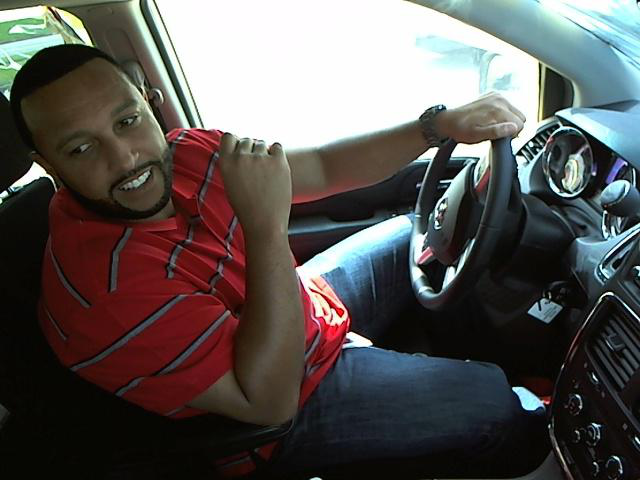

In [67]:
# load image
from PIL import Image
Image.open(os.path.join('nbs/data/statefarm/test/unknown','img_81601.jpg'))

Another high prediction (~68%) was generated for `img_62885.jpg`, which classified the driver as talking on the phone (held up to the driver's left ear, class c4). The image below supports this prediction:

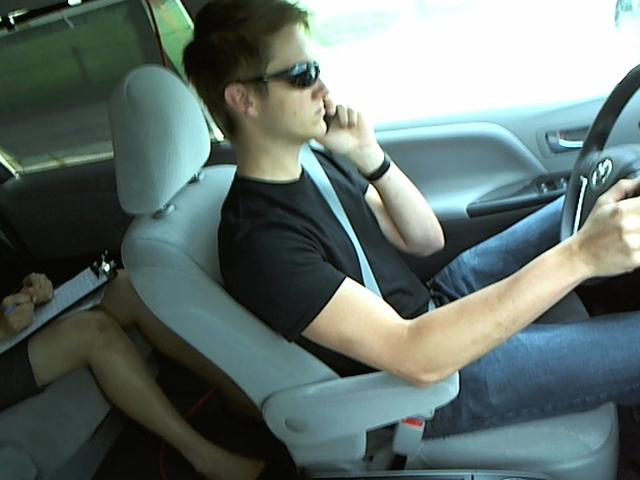

In [68]:
Image.open(os.path.join('nbs/data/statefarm/test/unknown','img_62885.jpg'))

Finally, we'll create the submission file:

In [64]:
submission.to_csv(subm_name, index=False, compression='gzip')

After submitting predictions to Kaggle, the loss was calculated as 0.70758, which would have ranked 413/1440. The competition has been closed since August 2016.